In [1]:
# для загрузки данных
import pandas_datareader.data as web

# для анализа
import numpy as np
import pandas as pd
import statsmodels.api as sm

# для визуализации
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 6)

pd.options.display.max_columns = 999
pd.options.display.max_rows = 150

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ссылка на статью 
# https://nagornyy.me/courses/data-science/time-series/

In [2]:
ACU = pd.read_csv(r'C:\Users\parsh\Desktop\Exchange\data\US_stocks_csv_85_89\US_stocks_csv_85_89\AMEX/ACU.csv', index_col=['Date'], parse_dates=['Date'])
ACU = ACU.Close
ACU = ACU.loc[:'1987-02-01']

In [3]:
SPY = pd.read_csv(r'C:\Users\parsh\Desktop\Exchange\data\US_stocks_csv_85_89\US_stocks_csv_85_89\Delisted/SPY-198707.csv', index_col=['Date'], parse_dates=['Date'])
SPY = SPY.Close
SPY = SPY.loc[:'1987-02-01']

In [4]:
ACU = ACU.groupby(pd.Grouper(freq='1D')).aggregate("mean")
SPY = SPY.groupby(pd.Grouper(freq='1D')).aggregate("mean")

In [5]:
ACU.index.rename('date', inplace=True)
SPY.index.rename('date', inplace=True)

In [6]:
ACU = ACU.rename("ACU_price");
SPY = SPY.rename("SPY_price");

In [7]:
df = pd.DataFrame([ACU, SPY]).T
df.head()

,ACU_price,SPY_price
date,,
1985-01-02,9.875,22.0
1985-01-03,10.000,22.5
1985-01-04,9.875,22.5
1985-01-05,NaN,NaN
1985-01-06,NaN,NaN


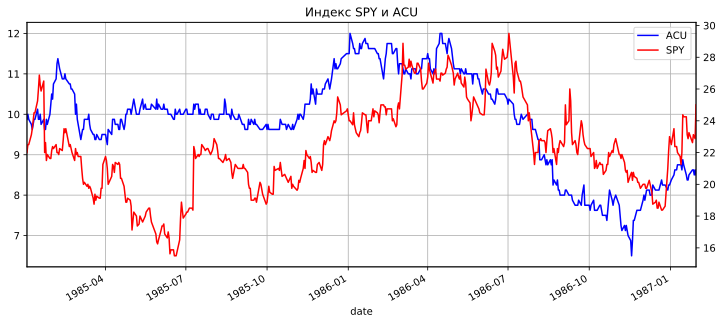

In [9]:
plt.figure(figsize=(12,5))
plt.title('Индекс SPY и ACU')

ax1 = df.dropna().ACU_price.plot(color='blue', grid=True, label='ACU')
ax2 = df.dropna().SPY_price.plot(color='red', grid=True, secondary_y=True, label='SPY')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [10]:
# для расчёта корреляции необходимо удалить пропущенные значения
corr = df.dropna().ACU_price.corr(
    df.dropna().SPY_price
)
"Correlation is {:.3}".format(corr)

'Correlation is 0.403'

In [11]:
pct_corr = df.dropna().ACU_price.pct_change().corr(
    df.dropna().SPY_price.pct_change()
)

"Percent change correlation is {:.3}".format(pct_corr)

'Percent change correlation is 0.0469'

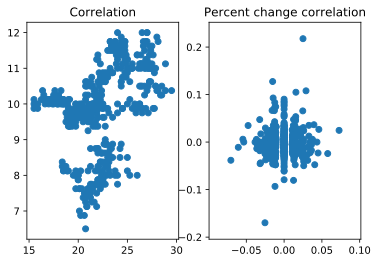

In [12]:
plt.subplot(1, 2, 1)
plt.scatter(
    df.dropna().SPY_price,
    df.dropna().ACU_price);
plt.title('Correlation')

plt.subplot(1, 2, 2)
plt.scatter(
    df.dropna().ACU_price.pct_change(),
    df.dropna().SPY_price.pct_change());
plt.title('Percent change correlation');

In [13]:
# Add a constant to the DataFrame x
reg_def = sm.add_constant(df.dropna())

# Fit the regression of y on x
result = sm.OLS(reg_def.ACU_price, reg_def[['const', 'SPY_price']]).fit()

# Print out the results
result.summary()

C:\Users\parsh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ACU_price   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     95.81
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           8.55e-21
Time:                        22:45:21   Log-Likelihood:                -753.26
No. Observations:                 495   AIC:                             1511.
Df Residuals:                     493   BIC:                             1519.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1091      0.386     15.823      0.000       5.351       6.868
SPY_price      0.1672      0.017      9.789      0.000       0.134       0.201
==============================================================================
Omnibus:                       43.547   Durbin-Watson:                   0.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.691
Skew:                          -0.711   Prob(JB):                     7.26e-11
Kurtosis:                       2.507   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
df_monthly = df.resample('M').last()
df_monthly.head()

,ACU_price,SPY_price
date,,
1985-01-31,10.375,22.375
1985-02-28,9.875,22.000
1985-03-31,9.500,21.250
1985-04-30,10.000,18.625
1985-05-31,10.250,16.500


In [15]:
"Price autocorr {:.3}, Percent Change autocorr {:.3}".format(
    df_monthly.SPY_price.autocorr(),
    df_monthly.SPY_price.pct_change().autocorr()
)

'Price autocorr 0.622, Percent Change autocorr -0.172'

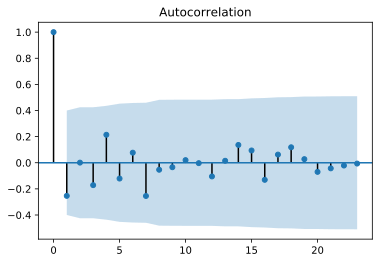

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf # для посчёта функции при разные значениях лага

plot_acf(df_monthly.SPY_price.diff().dropna());

In [18]:
from statsmodels.tsa.stattools import adfuller

adfuller_p = adfuller(df_monthly['ACU_price'])[1]

f"p-value of ADF-test {adfuller_p:.3}"

'p-value of ADF-test 0.201'

In [19]:
from statsmodels.tsa.arima_model import ARMA

# Forecast the first AR(1) model
mod = ARMA(df_monthly['ACU_price'].dropna(), order=(1, 0));
res = mod.fit();
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              ACU_price   No. Observations:                   25
Model:                     ARMA(1, 0)   Log Likelihood                 -20.240
Method:                       css-mle   S.D. of innovations              0.527
Date:                Sun, 21 Jul 2019   AIC                             46.480
Time:                        22:45:54   BIC                             50.137
Sample:                    01-31-1985   HQIC                            47.495
                         - 01-31-1987                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.6780      0.738     13.106      0.000       8.231      11.125
ar.L1.ACU_price     0.8877      0.080     11.156      0.000       0.732       1.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1265           +0.0000j            1.1265            0.0000
-----------------------------------------------------------------------------
"""

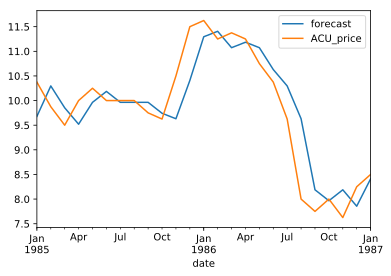

In [20]:
res.plot_predict(start=0, end="1987-01");

C:\Users\parsh\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


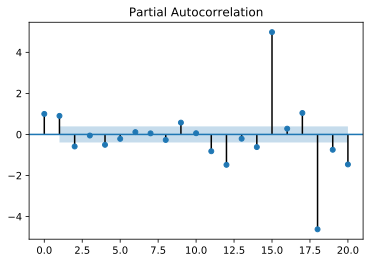

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_monthly['ACU_price'].dropna(), lags=20);

In [22]:
for order in range(1, 5):
    mod = ARMA(df_monthly['ACU_price'].dropna(), order=(order, 0))
    res = mod.fit();
    print("Order: {}\nBIC: {}\nAIC: {}\n".format(order, res.bic, res.aic))

Order: 1
BIC: 50.13701638640134
AIC: 46.480388911796744

Order: 2
BIC: 47.20585574942158
AIC: 42.330352449948776

Order: 3
BIC: 50.39853627028832
AIC: 44.304157145947315

Order: 4
BIC: 48.21651493400842
AIC: 40.90325998479922



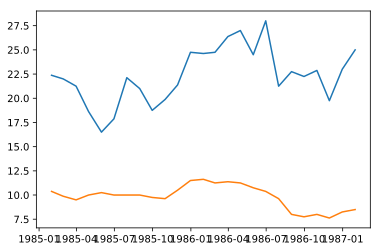

In [23]:
plt.plot(df_monthly.SPY_price, label='SPY_price')
plt.plot(df_monthly.ACU_price, label='ACU_price');

In [24]:
reg_def = sm.add_constant(df_monthly.dropna())
result = sm.OLS(reg_def['ACU_price'], reg_def['SPY_price']).fit()
result.params.SPY_price

0.4350659032072445

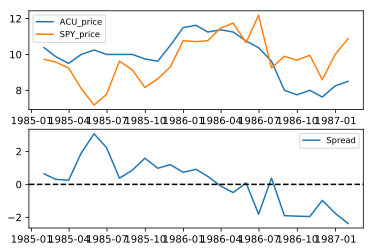

In [25]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(df_monthly.ACU_price, label='ACU_price')
plt.plot(df_monthly.SPY_price  * result.params.SPY_price, label='SPY_price')
plt.legend(loc='best', fontsize='small')


# Plot the spread
plt.subplot(2,1,2)
plt.plot(df_monthly.ACU_price - df_monthly.SPY_price * result.params.SPY_price, label="Spread")
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k');

In [26]:
from statsmodels.tsa.stattools import adfuller

result_ACU = adfuller(df_monthly['ACU_price'])
result_SPY = adfuller(df_monthly['SPY_price'])
print(f"The p-value for the ADF test on ACU_price is {result_ACU[1]:.2}, on SPY_price is {result_SPY[1]:.2}")

result_spread = adfuller(df_monthly.ACU_price - df_monthly.SPY_price * result.params.SPY_price)
print(f"The p-value for the ADF test on the spread is {result_spread[1]:.2}")

The p-value for the ADF test on ACU_price is 0.2, on SPY_price is 0.22
The p-value for the ADF test on the spread is 0.84


In [27]:
SPY_month = df.SPY_price.resample("W").last()

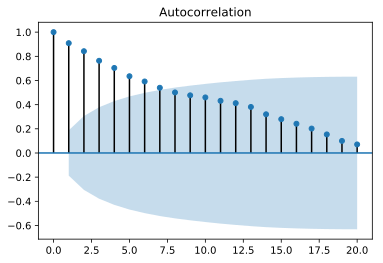

In [28]:
plot_acf(SPY_month, lags=20);

In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(SPY_month, order=(5,1,0));
model_fit = model.fit();
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.SPY_price   No. Observations:                  108
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -176.105
Method:                       css-mle   S.D. of innovations              1.235
Date:                Sun, 21 Jul 2019   AIC                            366.210
Time:                        22:46:22   BIC                            384.985
Sample:                    01-13-1985   HQIC                           373.822
                         - 02-01-1987                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0153      0.098      0.156      0.876      -0.176       0.207
ar.L1.D.SPY_price    -0.1011      0.098     -1.033      0.304      -0.293       0.091
ar.L2.D.SPY_price     0.0296      0.098      0.301      0.764      -0.163       0.223
ar.L3.D.SPY_price    -0.0789      0.104     -0.756      0.452      -0.284       0.126
ar.L4.D.SPY_price     0.0333      0.104      0.319      0.750      -0.171       0.238
ar.L5.D.SPY_price    -0.1066      0.109     -0.979      0.330      -0.320       0.107
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3598           -0.0000j            1.3598           -0.5000
AR.2           -0.4391           -1.5586j            1.6192           -0.2937
AR.3           -0.4391           +1.5586j            1.6192            0.2937
AR.4            1.2750           -1.0026j            1.6220           -0.1061
AR.5            1.2750           +1.0026j            1.6220            0.1061
-----------------------------------------------------------------------------
"""

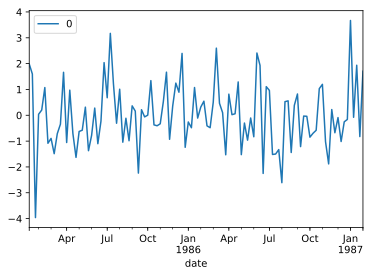

In [30]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

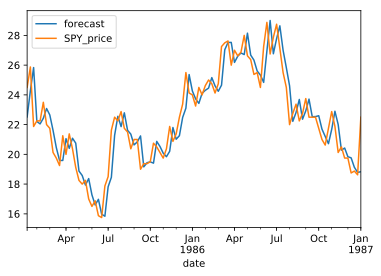

In [31]:
model_fit.plot_predict(end="1987-01-04");